# Train the classifier data for P5 vehicle
step 1:Observe the training data

In [57]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random




vehicle_imgs = list(glob.glob('./vehicles/**/*.png'))
nonvehicle_imgs = list(glob.glob('./non-vehicles/**/*.png'))

sample_img = random.sample(vehicle_imgs, 1)[0]
img = cv2.imread(sample_img)

print('Total %d vehicle images' % len(vehicle_imgs))
print('Total %d non-vehicle images' % len(nonvehicle_imgs))
print('There are about the same size of both classes')

print('images has shape', img.shape, 'and dtype', img.dtype)
print('Pixel value range approximately from', np.max(img), 'to', np.min(img))




Total 8792 vehicle images
Total 8968 non-vehicle images
There are about the same size of both classes
images has shape (64, 64, 3) and dtype uint8
Pixel value range approximately from 255 to 7


In [58]:
from mpl_toolkits.mplot3d import Axes3D

convertors = {
    'RGB': cv2.COLOR_BGR2RGB,
    'HLS': cv2.COLOR_BGR2HLS,
    'YUV': cv2.COLOR_BGR2YUV,
    'YCrCb': cv2.COLOR_BGR2YCrCb,
    'Lab': cv2.COLOR_BGR2Lab,
    'Luv': cv2.COLOR_BGR2Luv,
}
def plot3d(car_pixels, non_car_pixels):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    axis_limits=np.concatenate((car_pixels,non_car_pixels), axis=0)

    # Set axis limits
    ax.set_xlim(np.min(axis_limits[:,0]),np.max(axis_limits[:,0]))
    ax.set_ylim(np.min(axis_limits[:,1]),np.max(axis_limits[:,1]))
    ax.set_zlim(np.min(axis_limits[:,2]),np.max(axis_limits[:,2]))

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, 0].ravel(),
        pixels[:, 1].ravel(),
        pixels[:, 2].ravel(),
        c='g', edgecolors='none') #set the color to be green
    ax.scatter(
        pixels[ :, 0].ravel(),
        pixels[ :, 1].ravel(),
        pixels[ :, 2].ravel(),
        c='b', edgecolors='none') #set the color to be blue

    return ax  # return Axes3D object for further manipulation

def observe_colorspace():
    sample_car_imgs = random.sample(vehicle_imgs, 100)
    sample_noncar_imgs = random.sample(nonvehicle_imgs, 100)

    for name, convertor in convertors.items():
        car_pixels = []
        noncar_pixels = []
        samples_per_pic = 10

        for car_img in sample_car_imgs:
            img = cv2.imread(car_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            car_pixels.append(sample_pixels)

        for noncar_img in sample_noncar_imgs:
            img = cv2.imread(noncar_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            noncar_pixels.append(sample_pixels)

        car_pixels = np.vstack(car_pixels)
        noncar_pixels = np.vstack(noncar_pixels)

        ax = plot3d(car_pixels, noncar_pixels)
        plt.title(name)
       # plot different view points
        for ii in range(0,360,5):
            ax.view_init(elev=10., azim=ii)
            plt.savefig("./color_spaces/%s%d.png" % (name, ii))
        
#observe_colorspace()


In [59]:
# Extact color histogram features

def color_hist(img, nbins=128, bins_range=(0, 256), visualize=False):
    channel1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    if visualize:
        print(features.shape)
        return features, (channel1, channel2, channel3)
    else:
        return features
    
img_name = vehicle_imgs[0]
print('reading ', img_name)
img = cv2.imread(vehicle_imgs[0])

features, histograms = color_hist(img, visualize=True)
hist1, hist2, hist3 = histograms

# visualize histogram
# calculate bin center
bin_edges = hist1[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, hist1[0])
plt.xlim(0, 256)
plt.title('H histogram')
plt.subplot(132)
plt.bar(bin_centers, hist2[0])
plt.xlim(0, 256)
plt.title('L hist')
plt.subplot(133)
plt.bar(bin_centers, hist3[0])
plt.xlim(0, 256)
plt.title('S histogram')
plt.savefig('./report_file/color_hist.png')

reading  ./vehicles/GTI_Far/image0000.png
(384,)


In [60]:
# Extract spatial bin features

def bin_spatial(img, size=(16, 16)):
    resize_img = cv2.resize(img, size)
    color1 = resize_img[:,:,0].ravel()
    color2 = resize_img[:,:,1].ravel()
    color3 = resize_img[:,:,2].ravel()
    features = np.hstack((color1, color2, color3))
    return features

img_name = vehicle_imgs[0]
print('reading ', img_name)
img = cv2.imread(vehicle_imgs[0])
features = bin_spatial(img)
print(features.shape)


reading  ./vehicles/GTI_Far/image0000.png
(768,)


/Users/steveho/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


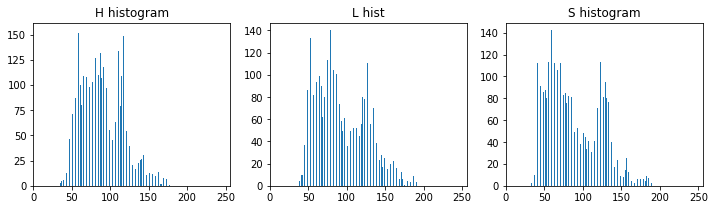

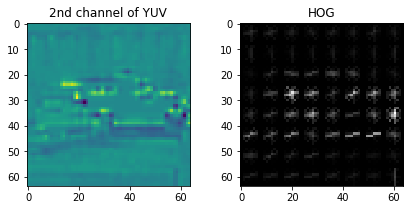

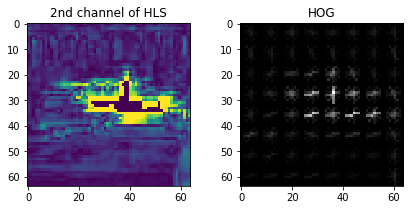

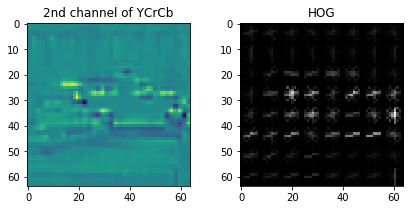

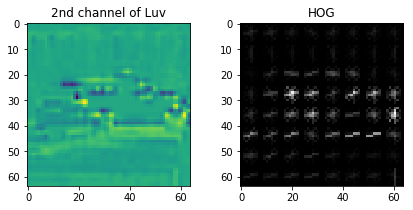

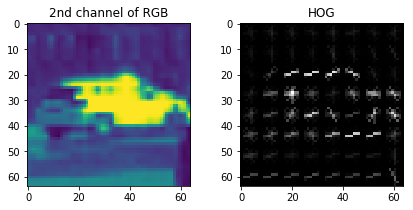

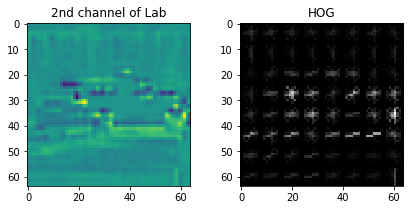

In [61]:
# Extract hog features
from skimage.feature import hog
"""
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=False):
    return hog(
        img, orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),##cell size,passed as a 2-tuple
        cells_per_block=(cell_per_block, cell_per_block),##
        visualise=vis, feature_vector=feature_vec)"""
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


        
img = cv2.imread(random.sample(vehicle_imgs, 1)[0])
for key in convertors:
    cpimg = np.copy(img)
    cvt_img = cv2.cvtColor(cpimg, convertors[key])
    one_channel = cvt_img[:,:,2]
    features, hog_image = get_hog_features(one_channel, vis=True)
    #plot from example(this plot is from pratice
    fig = plt.figure(figsize=(7,3))
    plt.subplot(121)
    plt.imshow(one_channel)
    plt.title('2nd channel of %s'%key)
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG')
    plt.savefig('./report_file/hog_%s.png' % key)
    plt.show()

In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

nbins = 128

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = color_hist(cvt_img, nbins=nbins)
    return features

def train_with_color_hist(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))

print(nbins,'color histogram')
for key in convertors:
    train_with_color_hist(cspace=key)


128 color histogram
YUV :
| YUV | 10.18 | 0.9307 |
HLS :
| HLS | 5.45 | 0.9634 |
YCrCb :
| YCrCb | 10.25 | 0.9392 |
Luv :
| Luv | 7.97 | 0.9378 |
RGB :
| RGB | 12.32 | 0.9209 |
Lab :
| Lab | 5.76 | 0.9566 |


In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

nbins = 64

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = color_hist(cvt_img, nbins=nbins)
    return features

def train_with_color_hist(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))

print(nbins,'color histogram')
for key in convertors:
    train_with_color_hist(cspace=key)

64 color histogram
YUV :
| YUV | 7.09 | 0.9226 |
HLS :
| HLS | 6.78 | 0.9575 |
YCrCb :
| YCrCb | 6.48 | 0.9350 |
Luv :
| Luv | 5.75 | 0.9319 |
RGB :


In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

nbins = 32

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = color_hist(cvt_img, nbins=nbins)
    return features

def train_with_color_hist(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))

print(nbins,'color histogram')
for key in convertors:
    train_with_color_hist(cspace=key)



In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

size=(32,32)

# Define a function to return HOG features and visualization

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = bin_spatial(cvt_img, size=size)
    return features

def train_with_bin_spatial(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))
print(size,'full color channel spatial bin')
for key in convertors:
    train_with_bin_spatial(cspace=key)

In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

size=(16,16)

# Define a function to return HOG features and visualization

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = bin_spatial(cvt_img, size=size)
    return features

def train_with_bin_spatial(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))
print(size,'full color channel spatial bin')
for key in convertors:
    train_with_bin_spatial(cspace=key)

In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

size=(8,8)

# Define a function to return HOG features and visualization

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = bin_spatial(cvt_img, size=size)
    return features

def train_with_bin_spatial(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))
print(size,'full color channel spatial bin')
for key in convertors:
    train_with_bin_spatial(cspace=key)

In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split


# Define a function to return HOG features and visualization
# change the value for orient,pix_per_cell, cell_per_block

def extract_features(img, cspace='RGB',orient=9, pix_per_cell=8, cell_per_block=2):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    channel1 = get_hog_features(cvt_img[:,:,0], orient,pix_per_cell,cell_per_block).ravel()
    channel2 = get_hog_features(cvt_img[:,:,0], orient,pix_per_cell,cell_per_block).ravel()
    channel3 = get_hog_features(cvt_img[:,:,0], orient,pix_per_cell,cell_per_block).ravel()
    return np.concatenate((channel1, channel2, channel3))

def train_with_hog_features(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))
  
for key in convertors:
    train_with_hog_features(cspace=key)

In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split


# Define a function to return HOG features and visualization
# change the value for orient,pix_per_cell, cell_per_block

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    
    channel1 = get_hog_features(cvt_img[:,:,0]).ravel()
    channel2 = get_hog_features(cvt_img[:,:,1]).ravel()
    channel3 = get_hog_features(cvt_img[:,:,2]).ravel()
    return np.concatenate((channel1, channel2, channel3))

def train_with_hog_features(cspace):
    # extract features
    print(cspace, ':')
    t = time.time()
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    t1 = time.time()
    extration_time=t1-t
    
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t2 = time.time()
    svc.fit(X_train, y_train)
    t3 = time.time()
    train_duration = round(t3-t2, 2)
    t4 = time.time()
    accuracy = svc.score(X_test, y_test)
    t5 = time.time()
    predict_duration = round(t5-t4, 2)
    print('| %s | %.2f |%.2f |%.2f | %.4f |' % (cspace, extration_time,train_duration,predict_duration, accuracy))
  
for key in convertors:
    train_with_hog_features(cspace=key)

# store the data

In [ ]:
import pickle

scv = None
X_scaler = None
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 128
color_space = 'YCrCb'


def extract_features(img, cspace='HLS'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    
    hist_features = color_hist(cvt_img, nbins=hist_bins)
    bin_features = bin_spatial(cvt_img, size=spatial_size)
    hog_kwargs = {
        'orient': orient,
        'pix_per_cell': pix_per_cell, 
        'cell_per_block': cell_per_block,
    }
    
    channel1 = get_hog_features(cvt_img[:,:,0], **hog_kwargs).ravel()
    channel2 = get_hog_features(cvt_img[:,:,1], **hog_kwargs).ravel()
    channel3 = get_hog_features(cvt_img[:,:,2], **hog_kwargs).ravel()

    return np.concatenate((hist_features, bin_features, channel1, channel2, channel3))


t0 = time.time()
car_features = np.array([extract_features(img, cspace=color_space) for img in vehicle_imgs])
noncar_features= np.array([extract_features(img, cspace=color_space) for img in nonvehicle_imgs])
t1 = time.time()
extract_duration = round(t1 - t0, 2)

# define features
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
# define labels
y = np.hstack((np.ones(len(car_features)),
               np.zeros(len(noncar_features))))

rand_state = np.random.randint(0, 101)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
t2 = time.time()
svc.fit(X_train, y_train)
t3 = time.time()

train_duration = round(t3-t2, 2)
t4 = time.time()
accuracy = svc.score(X_test, y_test)
t5 = time.time()
score_duration = round(t5-t4, 2)

print('| Color space | Feature extraction | Training time | Predict Time | Accuract |')
print('|-------|-------|-------|-------|-------|')
print('| %s | %.2f | %.2f | %.2f | %.4f |' % (color_space, extract_duration, train_duration, score_duration, accuracy))


data_pickle = {
    'svc': svc,
    'scaler': X_scaler,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size': spatial_size,
    'hist_bins': hist_bins,
    'color_space': color_space,
}
filename = 'svc_pickle.p'
with open(filename, 'wb') as f:
     pickle.dump(data_pickle, f)
     print('params saved to %s' % filename)